# Analysis on leads' quality

For the text data cleaning

I used a package that I have created, it’s called PyGhaseel.

I does text cleaning for Arabic and English languages.

Please check it out : https://github.com/ATWltd/pyghaseel

Note: it’s still under development, and the released version is a beta version.

The version used in this project is a local version with some unreleased improvements.

You can uncomment and install these packages that you might need

In [78]:
!pip install fuzzywuzzy
!pip install plotly
!pip install gensim
!pip install webcolors

'/home/badawy/anaconda3/lib/python3.8/site-packages/pyghaseel/__init__.py'

In [77]:
import os
path = os.path.abspath(pyghaseel.__file__)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
import re
import pyghaseel.Cleaner
import swifter

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer

#Libraries for clustering
from sklearn.cluster import KMeans
from collections import Counter


# for plots
from bidi.algorithm import get_display
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import arabic_reshaper


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

from meaningless import *

access ar cleaner


[nltk_data] Downloading package stopwords to /home/badawy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


access en cleaner


Preparing Cleaning Functions

In [3]:
cleaner = pyghaseel.Cleaner()

def text_clean(text):
    return cleaner.clean(text, ar=True, en=True)

def removeMeaningless(text):
    for word in meaningless_words:
        text = text.replace(word, "")
    return text

Loading and Cleaning the data

In [62]:
df = pd.read_csv("nawy_dataset.csv")
df.drop(df.columns[[11,12]], axis=1, inplace=True)
df.head()

/home/badawy/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,lead_id,customer_name,lead_mobile_network,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified
0,22,Rajaa M.Mousa,Orange,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,generic form,none,google,dev_-_sodic,sodic october plaza,0
1,30,Sahar Shalaby,Vodafone,ad_id : 23843176891470664 \nform_id : 36774549...,2019-09-16 13:17:18.459000,facebook,o west - fb_creme de la creme_ cairo/giza_27-60,facebook,orascom - lead generation,o west,0
2,42,Mohamed,Vodafone,message:,2022-05-07 02:03:53.589687,generic form,gouna_-_properties,google,locations,el gouna for sale & resale,0
3,44,Maher Elnakib,Orange,ad_id : 23844249544660664 \nadset_id : 2384424...,2019-12-19 22:56:46.662000,facebook,new release north edge general with north coas...,facebook,city edge - lead generation,north edge,0
4,48,pierre,Vodafone,message:,2022-01-27 05:56:22.806753,top compounds form,none,google,dev_-_inertia_egypt,joulz,0


In [5]:
df['low_qualified'] = pd.to_numeric(df['low_qualified'], errors="coerce")
df.dropna(subset = ["low_qualified"], inplace=True)

In [6]:
df['lead_time'] = pd.to_datetime(df['lead_time'], errors="coerce")
df.dropna(subset = ["lead_time"], inplace=True)

In [7]:
df.dtypes

lead_id                         int64
customer_name                  object
lead_mobile_network            object
message                        object
lead_time              datetime64[ns]
method_of_contact              object
ad_group                       object
lead_source                    object
campaign                       object
location                       object
low_qualified                 float64
dtype: object

In [8]:
columns = [
    "lead_mobile_network",
    "method_of_contact",
    "ad_group",
    "lead_source",
    "campaign",
    "location",
    "message"
]

In [9]:
df["total_words"] = ""

for column in columns:
    print(f"Cleaning column {column}")
    df[column] = df[column].apply(text_clean)
    df[column] = df[column].apply(removeMeaningless)
    df[column] = df[column].apply(lambda x:str(re.sub(' +', ' ', x)))
    df["total_words"] = df["total_words"] + " " + df[column]

Cleaning column lead_mobile_network
Cleaning column method_of_contact
Cleaning column ad_group
Cleaning column lead_source
Cleaning column campaign
Cleaning column location
Cleaning column message


**Let's inspect some columns by looking at the unique values**

In [10]:
unique_values = df[columns].nunique()
unique_values

Now let's look at the unique values, and decide what to do


lead_mobile_network        8
method_of_contact        123
ad_group                2317
lead_source              120
campaign                 481
location                2805
message                25471
dtype: int64

**This number of unique values is strange?!, for lead_mobile_network 8 is reasonable number, but what about the other fields?!**

**Let's inspect more**

In [11]:
columns = [
    "lead_mobile_network",
    "method_of_contact",
    "ad_group",
    "lead_source",
    "location",
]

for required_col in columns:
    print(f"Workin on column {required_col}")
    res = df.groupby(df[required_col].map(tuple))
    i = 0
    for group_id , group in res:
        print(f"-> {group[required_col].iloc[0]}")
        if i >= 10:
            break
        i+=1
    print()
    print("/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/")
    print()

Workin on column lead_mobile_network
-> 
-> etisalat
-> europe
-> gulf
-> orange
-> others
-> us canda
-> vodafone

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/

Workin on column method_of_contact
-> acgdigitalmarketingcom
-> akhbaraknet
-> ampprojectorg
-> app
-> appneilpatelcom
-> appsapplecom
-> bingcom
-> blog
-> blogwritrcom
-> call
-> call center resale

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/

Workin on column ad_group
-> 
->  
->  cairo
->  cairo projects website visitors
->  giza compounds general
->  giza general ar
->  giza resale cib lookalike
->  giza resale creme de la creme
->  giza resale general audience october interests
->  giza resale general audience real estate interests
->  giza resale mix lookalikes

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/

Workin on column lead_source
-> acgdigitalmarketingcom
-> akhbaraknet
-> ampprojectorg
-> app
-> appneilpatelcom
-> appsapplecom
-> bingcom
-> blog
-> blogwritrcom
-> call
-> call center resale

/\/\/

**Can you spot the repetition!, that doesn't look very good, we can't use "groupby", we need a better solution than grouping**

**So what about clustering?**

**Let's try kmeans clustering**

In [12]:
def cluster(column, n_clusters):
    vectorizer_cv = CountVectorizer(analyzer='word')
    X_cv = vectorizer_cv.fit_transform(df[column])
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_cv)
    result = pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())
    return kmeans.predict(X_cv)


def getStatisticsOnClustered(df, clustered_column, column_of_interest, stats, n):
    res = df.groupby(clustered_column).agg({column_of_interest: stats})
    res = res[column_of_interest]
    return res[res["mean"]>0].nsmallest(n=n, columns=['mean']), res.nlargest(n=n, columns=['mean'])


def plotQualityAnalysis(df, smallest_stats, largest_stats, column_name, is_clustered=False):
    
    if is_clustered:
        clustered_column_name = column_name+"_clustered"
    else:
        clustered_column_name = column_name
    
    fig, axs = plt.subplots(2,2, figsize=(15, 10))
    
    fig.suptitle(f'Plotting top smallest/largest {column_name}')
    
    smallest_x = list(map(str, smallest_stats.index))

    smallest_summ = smallest_stats["sum"].to_list()
    smallest_count = smallest_stats["count"].to_list()
    smallest_mean = list(map(lambda x: x*100, smallest_stats["mean"].to_list()))
    
    largest_x = list(map(str, largest_stats.index))

    largest_summ = largest_stats["sum"].to_list()
    largest_count = largest_stats["count"].to_list()
    largest_mean = list(map(lambda x: x*100, largest_stats["mean"].to_list()))

    x_axis = np.arange(len(smallest_x))
    
    width = 0.3
    margin = 0.15
    
#     smallest_cluster_sampe = df[df[clustered_column_name].isin(smallest_stats.index)][column_name].nlargest(n=5, columns=['mean'])
    axs[0, 0].set_title(f'Clusters with the smallest good leads ratio')
    axs[0, 0].bar(x_axis -margin, smallest_summ, width=width, label='Good Leads Count')
    axs[0, 0].bar(x_axis +margin, smallest_count, width=width, label='Leads Count')
    axs[0, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
    axs[0, 0].legend()
    
    axs[1, 0].bar(x_axis , smallest_mean, width=width, label = 'Good Leads to Total Leadss Ratio', color="green")
    axs[1, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
    axs[1, 0].legend()
    
#     largest_cluster_sampe = df[df[clustered_column_name].isin(largest_stats.index)][column_name].nsmallest(n=5, columns=['mean'])
    axs[0, 1].set_title(f'Clusters with the largest good leads ratio')
    axs[0, 1].bar(x_axis -margin, largest_summ, width=width, label='Good Leads Count')
    axs[0, 1].bar(x_axis +margin, largest_count, width=width, label='Leads Count')
    axs[0, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)
    axs[0, 1].legend()
    
    axs[1, 1].bar(x_axis , largest_mean, width=width, label = 'Good Leads to Total Leadss Ratio', color="green")
    axs[1, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)
    axs[1, 1].legend()

In [13]:
columns = {
    "lead_source":40,
    "method_of_contact":13,
    "location":500,
    "ad_group":500
}

for key, n_clusters in columns.items():
    df[key+'_clustered'] = cluster(key, n_clusters)

**Now for each of the clusters we will use each one of them we just created to do analysis on each cluster**

**we will group each cluster for every column by lead quality and see the relationship between clusters and leads' quality**

<ipython-input-12-1d2b720fe12f>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:52: UserWarning: FixedFormatter should only be use

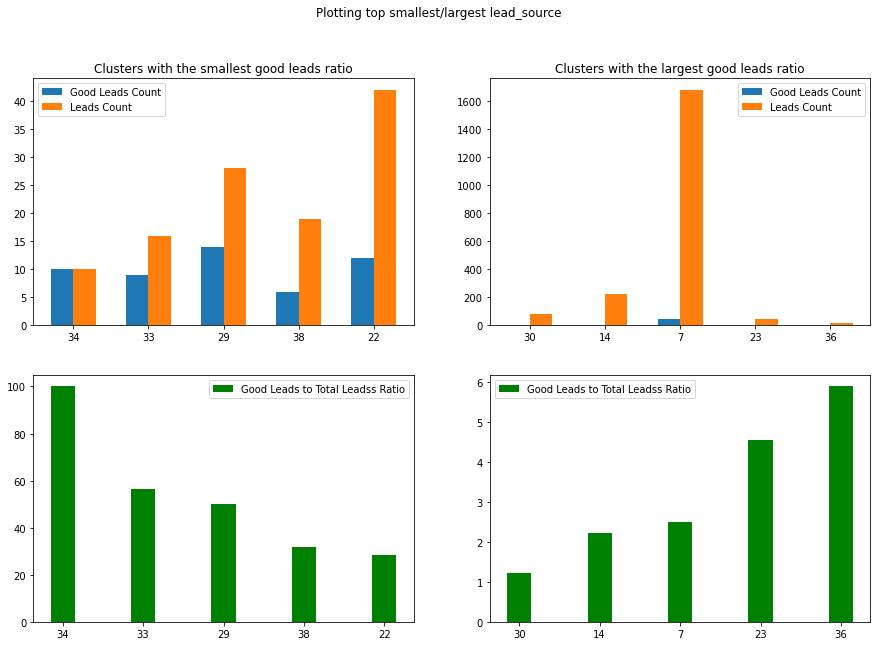

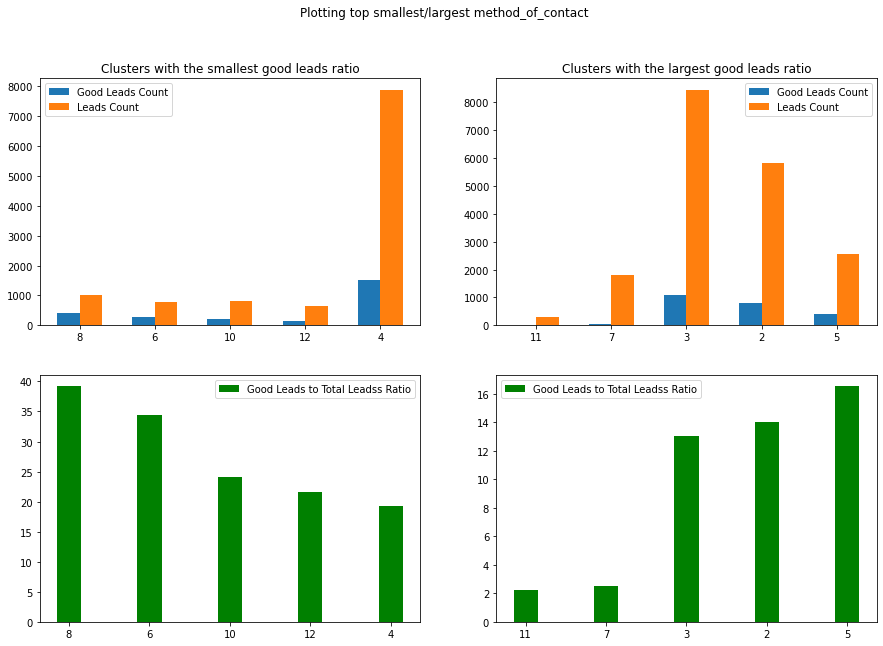

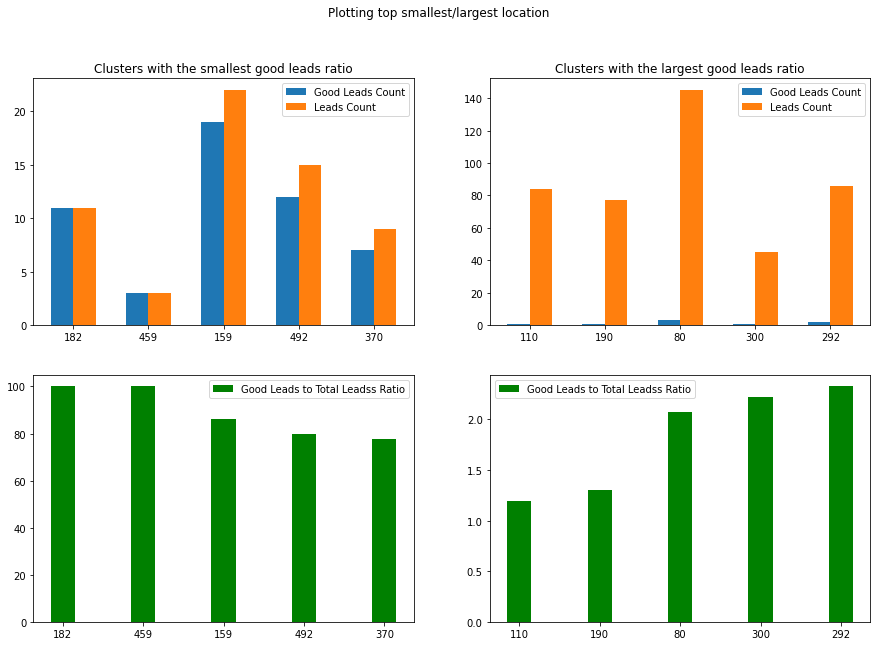

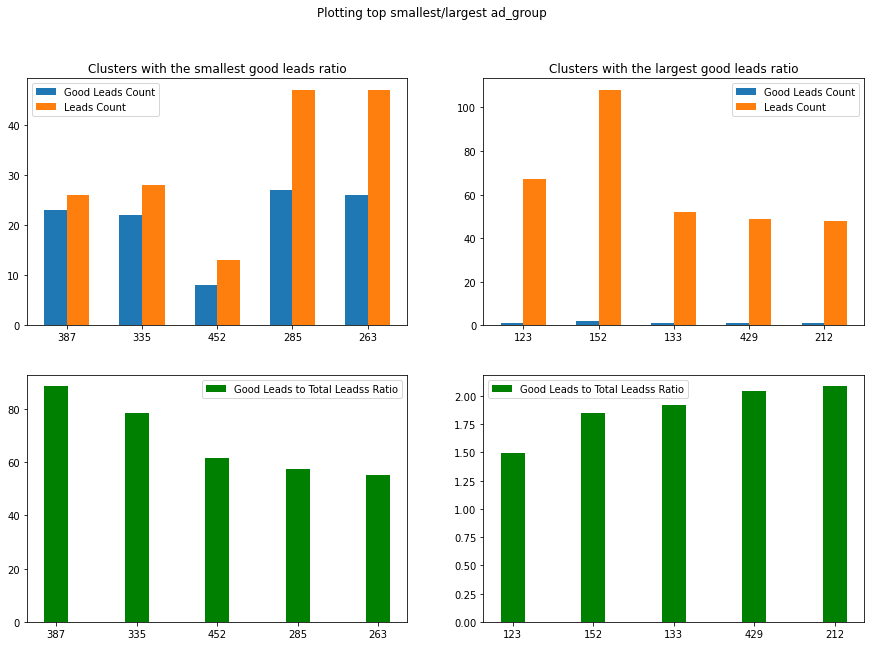

In [14]:
for column in columns.keys():
    smallest, largest = getStatisticsOnClustered(df, column+"_clustered", "low_qualified", ['sum', 'mean', 'count'], 5)
    plotQualityAnalysis(df, largest, smallest, column, True)

So let's try to inspect more using grouping

<ipython-input-12-1d2b720fe12f>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels([""]+smallest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)
<ipython-input-12-1d2b720fe12f>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels([""]+largest_x, fontdict=None, minor=False)


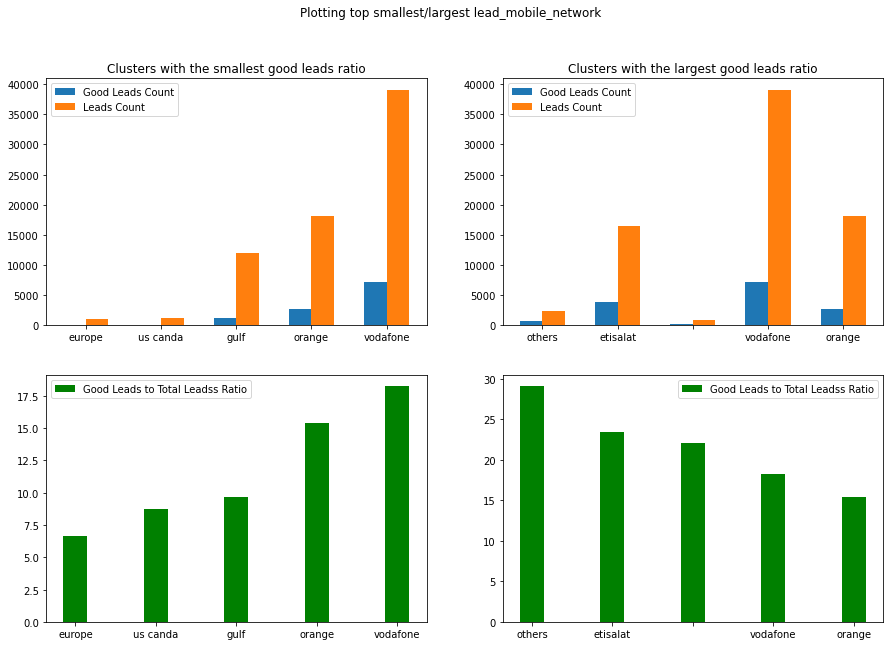

In [15]:
column = "lead_mobile_network"

smallest, largest = getStatisticsOnClustered(df, column, "low_qualified", ['sum', 'mean', 'count'], 5)
plotQualityAnalysis(df, smallest, largest, column)

Note that we are need to look both to the counts and the ratio, as we need both, we don't care for high ration while count is almost 0
On the other hand we cant look to a high good leads count without looking to its ratio
We need to look at both of them

**So we see that some values/clusters of some categorical columns has more high quality leads than other values/clusters**

**Now let's try to clean the messages column more, to analyze its content**

In [16]:
def removeMessagesMeaningless(text):
    for word in messages_meaningless_words:
        text = text.replace(word, "")
    return text

df["message"] = df["message"].apply(removeMessagesMeaningless)

In [17]:
poor_text = " ".join(df[df["low_qualified"] == 0]["message"]).split()
print(len(poor_text))

good_text = " ".join(df[df["low_qualified"] == 1]["message"]).split()
print(len(good_text))

348411
64862


In [18]:
poor_counter = Counter(poor_text)#.most_common(500)
# print([x[0] for x in poor_counter])
good_counter = Counter(good_text)#.most_common(500)
# print(good_counter.keys())
# print([x[0] for x in good_counter])

In [19]:
get_keys = lambda x: x[0]
get_values = lambda x: x[1]

def plotCounter(my_counter, most_common=20):
    keys = list(map(get_keys, my_counter.most_common(most_common)))
    values = list(map(get_values, my_counter.most_common(most_common)))
    
    keys = [arabic_reshaper.reshape(x) for x in keys]
    keys = [get_display(x) for x in keys]

    plt.figure(figsize=(18,8))
    plt.bar(keys, values)
    plt.xticks(rotation=50)
    plt.xlabel("Word")
    plt.ylabel("Count")
    plt.show()

def generateWordCloud(my_counter):
    reversed_counter = Counter()
    i = 0
    for ele in my_counter:
        reversed_ele = arabic_reshaper.reshape(str(ele))
        reversed_ele = get_display(reversed_ele) # add this line
        reversed_counter[reversed_ele] = my_counter[ele]
        if i >= 500:
            break
        i+=1
    
    wordcloud = WordCloud(width = 1000, height = 500, background_color="white", font_path = 'arial.ttf')
    wordcloud = wordcloud.generate_from_frequencies(reversed_counter)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()
    del reversed_counter

# poor_counter.most_common(10)

**Some bar plots and Word1clouds may help us see the situation better**

Most used words in Low Quality leads


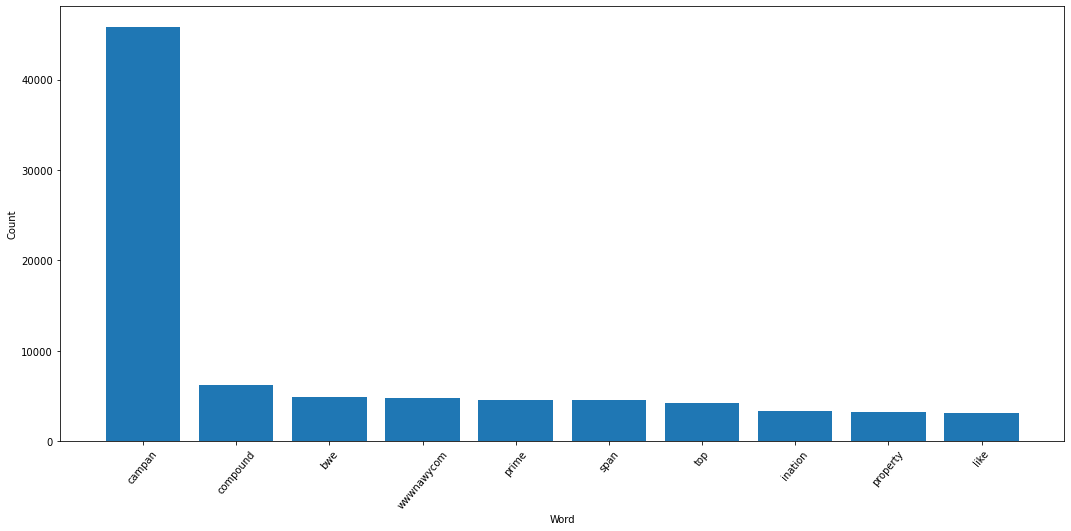

WordsCloud in Low Quality leads


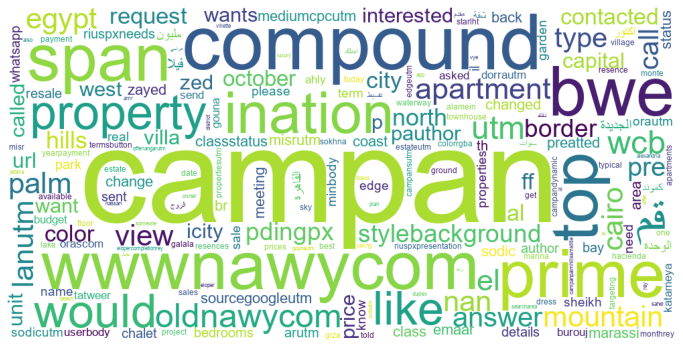

In [20]:
print("Most used words in Low Quality leads")
plotCounter(poor_counter, most_common=10)
print("WordsCloud in Low Quality leads")
generateWordCloud(poor_counter)

Most used words in High Quality leads


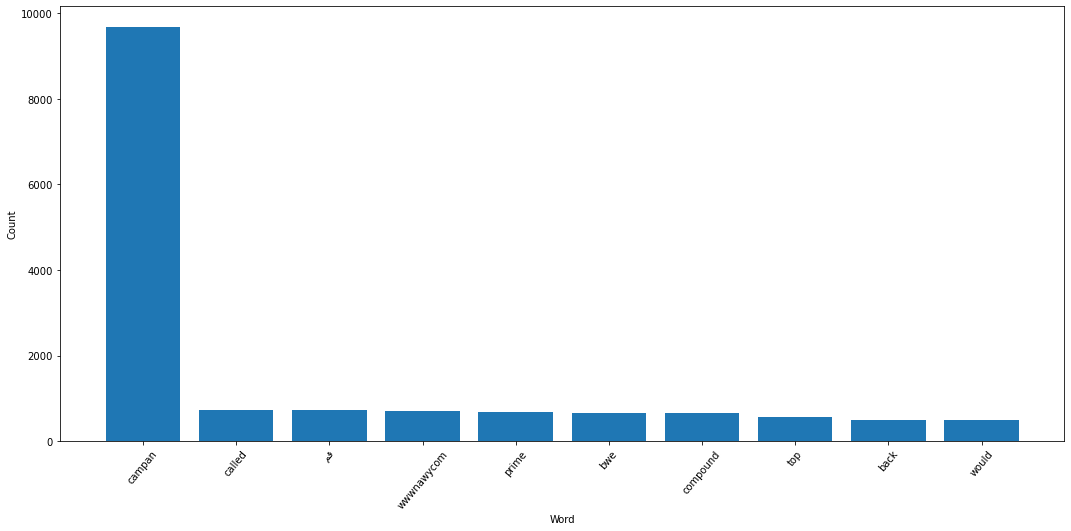

WordsCloud in High Quality leads


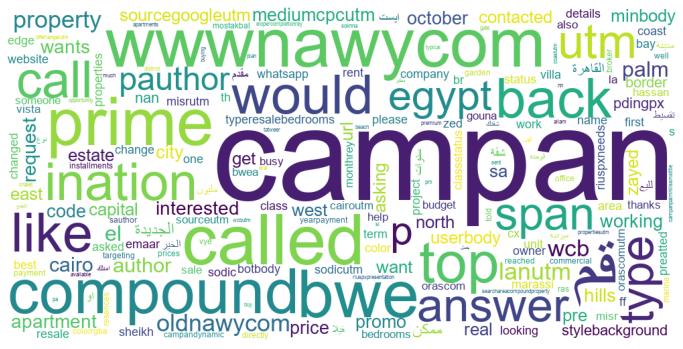

In [21]:
print("Most used words in High Quality leads")
plotCounter(good_counter, most_common=10)
print("WordsCloud in High Quality leads")
generateWordCloud(good_counter)

**Now let's take it a step further, what about trying to find the correlation between the count of the words in a message and the quality of the leads**

In [22]:
def getWordsCount(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0

df["message_words_count"] = df["message"].apply(getWordsCount)

In [23]:
df["message"]

0                 ea best area sheik za also villa prices
1                                                        
2                                                        
3                            campan          budget wrote
4                                                        
                               ...                       
91124    ميزانية مليون نوع الوحدة فيلا  campan           
91125                                      campan        
91126                                                    
91127                                      campan        
91128                                      campan        
Name: message, Length: 91121, dtype: object

In [24]:
df["message_words_count"]

0        8
1        0
2        0
3        3
4        0
        ..
91124    6
91125    1
91126    0
91127    1
91128    1
Name: message_words_count, Length: 91121, dtype: int64

In [25]:
# plt.matshow(df[["message_words_count", "low_qualified"]].corr())
# plt.show()

corr = df[["message_words_count", "low_qualified"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,message_words_count,low_qualified
message_words_count,1.000000,-0.014816
low_qualified,-0.014816,1.000000


**How disappointing! , the correlation is very weak, but we still going to take in consideration trying to find the reason**

In [26]:
df.columns

Index(['lead_id', 'customer_name', 'lead_mobile_network', 'message',
       'lead_time', 'method_of_contact', 'ad_group', 'lead_source', 'campaign',
       'location', 'low_qualified', 'total_words', 'lead_source_clustered',
       'method_of_contact_clustered', 'location_clustered',
       'ad_group_clustered', 'message_words_count'],
      dtype='object')

**Now for training the models**


**So let’s choose the best model for our case, and since our problem is just a simple binary classification, we can choose:**

- **Support Vector Classifier**
- **Linear regression**

**but first, let's check the imbalance in our data**

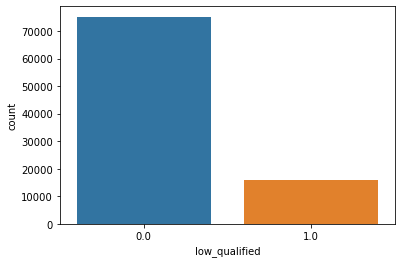

In [27]:
sns.countplot(x="low_qualified", data=df)
plt.show()

**Unfortunately there is an imbalance**

**so what are we going to do?**

- **Use balanced weight to the classes (instead of giving each class the same weight)**
- **Move our threshold to give a better**

**Now lets try to create features to train the models on**

**we may do**

- **clusters ids as a categorical features**
- **words in the messages (after the cleaning steps)**
- **all the words inside all the columns (after cleaning and before clustering)**

**Starting with clusters ids as a categorical features**

In [28]:
df = df.sample(frac=1).reset_index(drop=True)

X = df[['lead_source_clustered',
'method_of_contact_clustered', 'location_clustered',
'ad_group_clustered', 'message_words_count']]

y = df["low_qualified"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [29]:
logreg = LogisticRegression(class_weight="balanced")
# logreg = LogisticRegression(class_weight={0:1,1:6})
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [30]:
score = logreg.score(X_test, y_test)
print(score)

0.40717708600065844


In [31]:
predictions = logreg.predict(X_test)

In [32]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 7686 14834]
 [ 1372  3445]]


In [33]:


target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.34      0.49     22520
     class 1       0.19      0.72      0.30      4817

    accuracy                           0.41     27337
   macro avg       0.52      0.53      0.39     27337
weighted avg       0.73      0.41      0.45     27337



Text(0.5, 1.0, 'Accuracy Score: 0.40717708600065844')

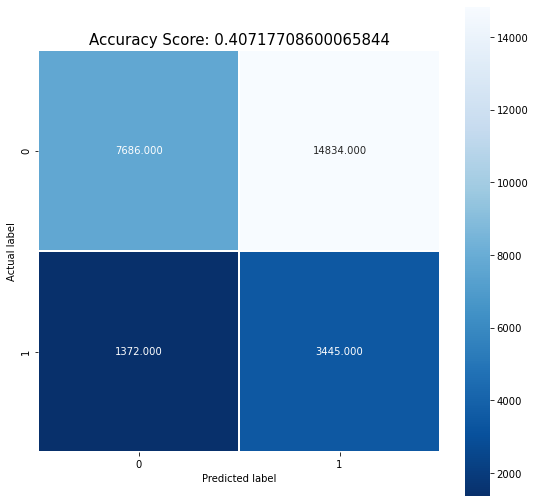

In [34]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [35]:
# svc = SVC(class_weight="balanced")
# svc.fit(X_train, y_train)

# score = svc.score(X_test, y_test)
# print(score)

# predictions = svc.predict(X_test)

# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)

# plt.figure(figsize=(9,9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score)
# plt.title(all_sample_title, size = 15);

**Then with words in the messages (after the cleaning steps)**

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df["message"])

X_train, X_test, y_train, y_test = train_test_split(X, df["low_qualified"], test_size=0.3, random_state=0)

In [37]:
logreg = LogisticRegression(max_iter=100000, class_weight="balanced")
# logreg = LogisticRegression(max_iter=100000, class_weight={0:1,1:6})
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

0.43142993013132386
              precision    recall  f1-score   support

     class 0       0.91      0.34      0.50     22520
     class 1       0.22      0.84      0.34      4817

    accuracy                           0.43     27337
   macro avg       0.56      0.59      0.42     27337
weighted avg       0.79      0.43      0.47     27337



Text(0.5, 1.0, 'Accuracy Score: 0.43142993013132386')

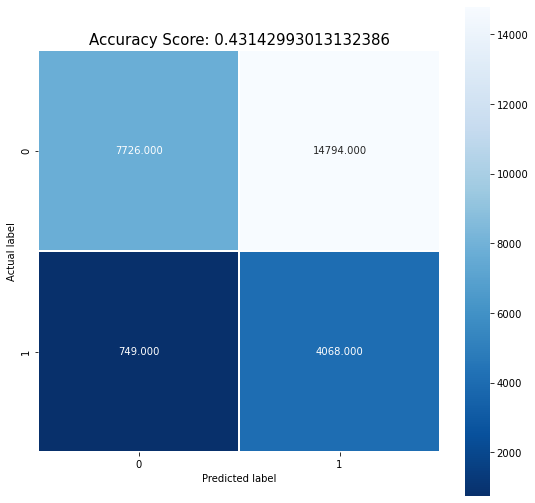

In [38]:
predictions = logreg.predict(X_test)

pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))


cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
score = logreg.score(X_test, y_test)
print(score)

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [39]:
# svc = SVC(class_weight="balanced")
# svc.fit(X_train, y_train)

# score = svc.score(X_test, y_test)
# print(score)

# predictions = svc.predict(X_test)

# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)

# plt.figure(figsize=(9,9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score)
# plt.title(all_sample_title, size = 15);

**Then with words inside all the columns (after cleaning and before clustering)**

0.5596078574825328
              precision    recall  f1-score   support

     class 0       0.92      0.51      0.66     22520
     class 1       0.26      0.78      0.39      4817

    accuracy                           0.56     27337
   macro avg       0.59      0.65      0.52     27337
weighted avg       0.80      0.56      0.61     27337



Text(0.5, 1.0, 'Accuracy Score: 0.5596078574825328')

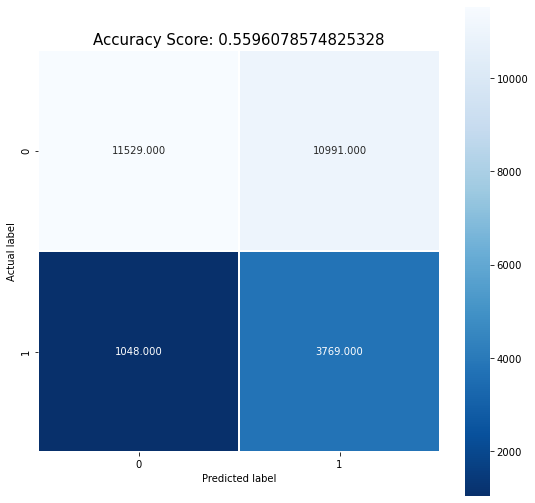

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(200)

X = vectorizer.fit_transform(df["total_words"])

X_train, X_test, y_train, y_test = train_test_split(X, df["low_qualified"], test_size=0.3, random_state=0)

# logreg = LogisticRegression(max_iter=100000, class_weight="balanced")
logreg = LogisticRegression(max_iter=100000, class_weight={0:1,1:8})
logreg.fit(X_train, y_train)


predictions = logreg.predict(X_test)

pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))


cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
score = logreg.score(X_test, y_test)
print(score)

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [42]:
# svc = SVC(class_weight="balanced")
# svc.fit(X_train, y_train)

# score = svc.score(X_test, y_test)
# print(score)

# predictions = svc.predict(X_test)

# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)

# plt.figure(figsize=(9,9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score)
# plt.title(all_sample_title, size = 15)

**So we can see that the approach of using the words inside all the columns (after cleaning and before clustering) is the better, it gave us:**
- Better precision
- Better f1 score 


**And they are the main two evaluation metrics we seek, because we care about good leads being mis-classified as bad lead than bad leads gets mis-classified as good leads**


**To improve the quality of our model we can do:**
- Extra cleaning the data by studying the nature of the data more.
- Spending more time upgrading the clusters’ quality
- Trying new types and architectures of models
- More studying to the nature of the data

**Now let's save the model and the vectorizer to be used in the deployment**

**I will use flask for deployment**

In [43]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

filename = 'finalized_vectiorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

# the deployed model in the file app.py (use the command: flask run --without-threads on bash to run the service)